### The Task:

A banking institution ran a direct marketing campaign based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed or not. We aim to predict whether someone will subscribe to the term deposit or not based on the given information. We approach the problem using simple machine learning models and then testing different ensemble methods to improve results.

### Importing Libraries and Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.sparse import hstack
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import mutual_info_classif, SelectPercentile, VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [3]:
data = pd.read_csv('data/data.csv')
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


### Exploration and Data Cleaning

First we separated the "subscribed" feature as our target variable and encoded it in binary form

In [4]:
subscribed = data['subscribed']
data.drop(['subscribed'], axis=1, inplace=True)
subscribed.replace(['yes', 'no'], [1, 0], inplace=True)
print("Percentage of customers who subscribed: {}".format((float(subscribed.sum()) / subscribed.shape[0])*100))

Percentage of customers who subscribed: 11.2655538695


Since only about 11% of customers subscribed, the dataset is rather imbalanced and we accounted for this in our analysis.

For most features, we treated 'unknown' values as another variable. However, for the 'prev_days' feature (how many days since the client was previously contacted), over 95% of the observations were 999, meaning the client had not previously been contacted. We decided to convert this into a variable encoding the number of weeks since the customer was previously contacted, and encoded 'Never' for the 999 values.

In [5]:
data['prev_days'].value_counts()

999    31707
3        373
6        332
4        105
9         55
7         48
2         46
12        45
5         42
10        40
13        26
11        23
1         19
15        18
14        17
8         13
0         11
16        10
17         5
18         4
19         3
22         3
21         2
26         1
20         1
27         1
Name: prev_days, dtype: int64

In [6]:
data['prev_weeks'] = pd.cut(data['prev_days'], bins = [0, 7, 14, 21, 30, 1000], 
                             labels = ["1", "2", "3", "4", "Never"], include_lowest=True)

In [7]:
data.prev_weeks.value_counts()

Never    31707
1          976
2          219
3           43
4            5
Name: prev_weeks, dtype: int64

In [8]:
data.drop(['duration', 'prev_days'], axis=1, inplace=True)

In [9]:
categorical_cols = ['job', 'marital_status', 'education', 'credit_default', 'housing', 'loan', 'contact', 'month', 
                    'day_of_week', 'prev_outcomes', 'prev_weeks']
continuous_cols = ['age', 'campaign', 'prev_contacts', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 
                   'euribor3m', 'nr_employed']

In [10]:
data_reorder = pd.concat((data[continuous_cols], data[categorical_cols]), axis=1)

#### Train Test Split

Here we split our dataset into a training and a testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_reorder, subscribed, stratify=subscribed, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

#### Distributions

Here we plot the distributions of the features in our dataset

In [54]:
def plot_distributions(data, columns, bins):
    fig, axes = plt.subplots(len(columns), figsize=(20,4*len(columns)))
    fig.subplots_adjust(hspace=1.5)
    axes = axes.ravel()
    for col in range(len(columns)):
        if bins==None:
            labels = data[columns[col]].value_counts().index
            y_pos = np.arange(len(labels))
            axes[col].bar(y_pos, data[columns[col]].value_counts(), align='center')
            axes[col].set_xticks(y_pos)
            axes[col].set_xticklabels(labels)
        else:
            axes[col].hist(data[columns[col]], bins = bins)
        axes[col].set_title(columns[col])

    plt.show()

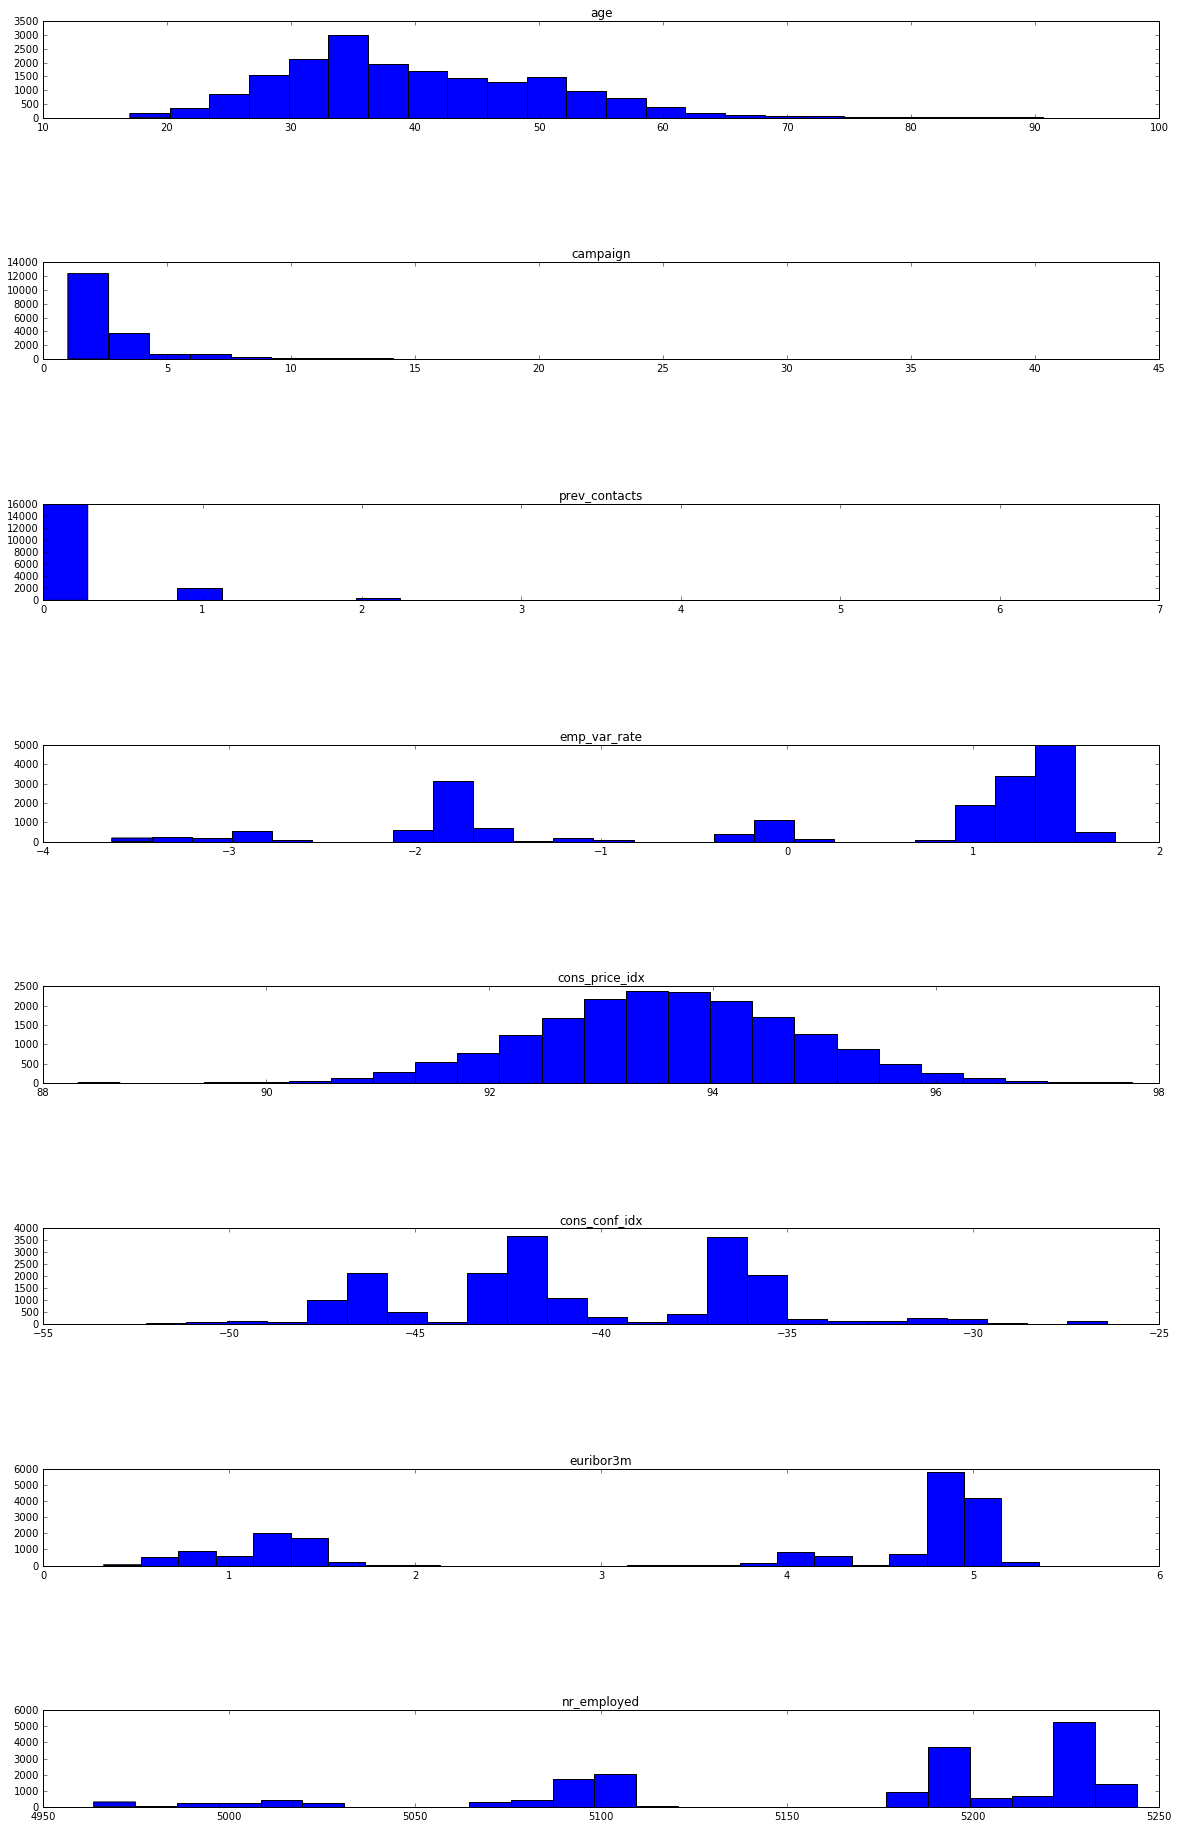

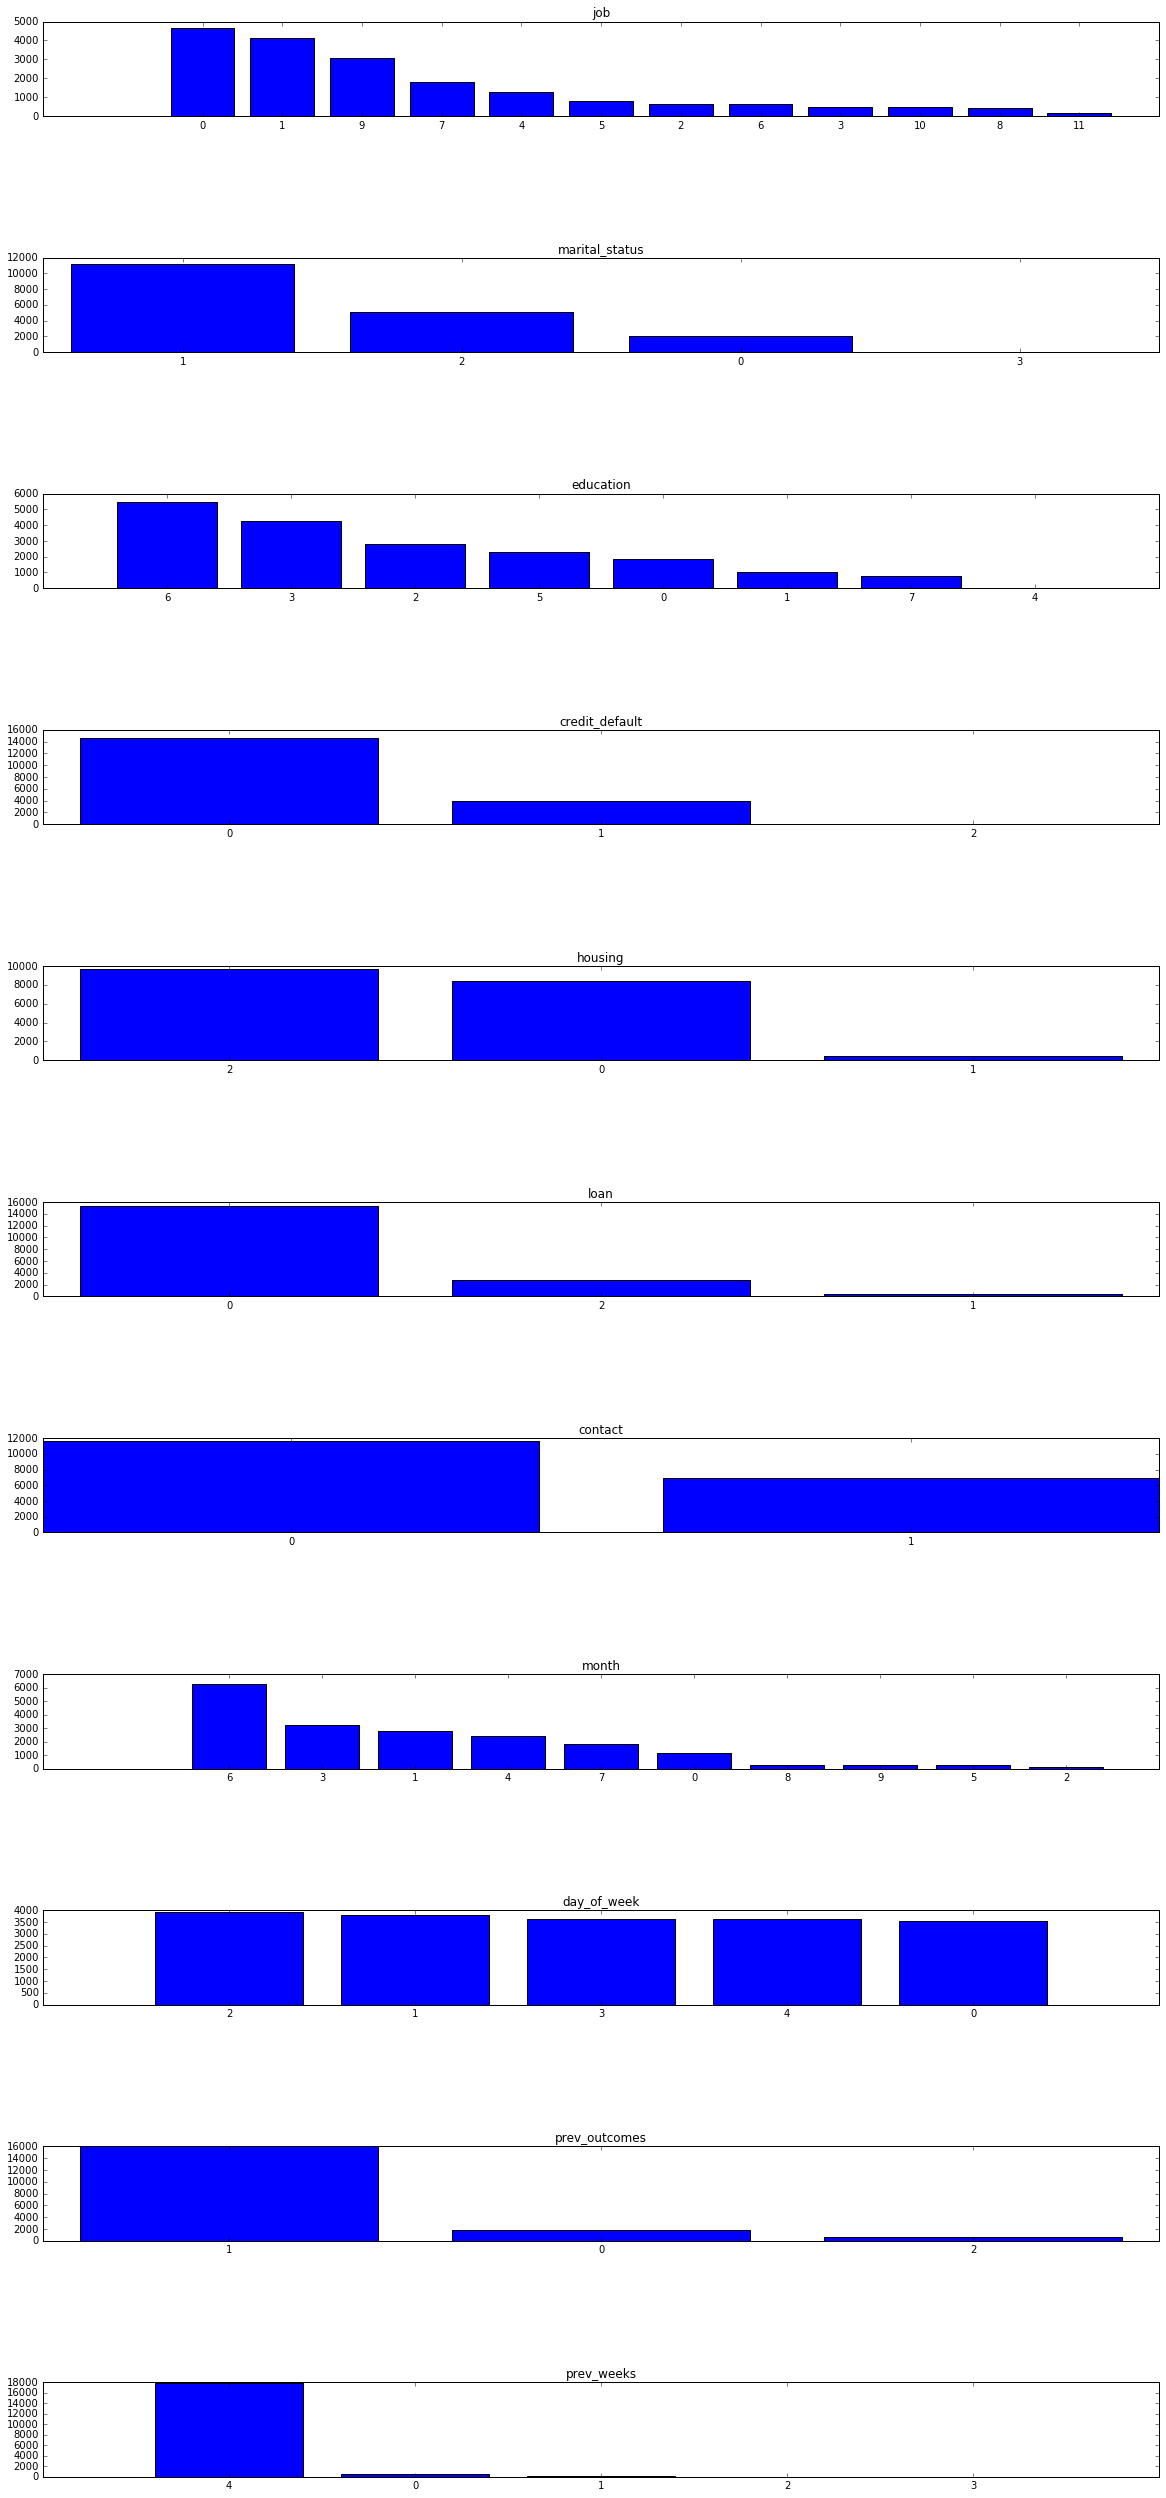

In [55]:
plot_distributions(X_train, continuous_cols, bins=25)
plot_distributions(X_train, categorical_cols, bins=None)

### Mutual Information

Here we plot the mutual information of each feature with our target variable to gain an understanding of which features are the most important for predicting whether or not a customer will subscribe to the bank term deposit

In [14]:
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')

In [15]:
mi_continuous = mutual_info_classif(X_train[continuous_cols], y_train, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)

categorical_train_dummies = pd.get_dummies(X_train[categorical_cols])
mi_categorical = mutual_info_classif(categorical_train_dummies, y_train, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)

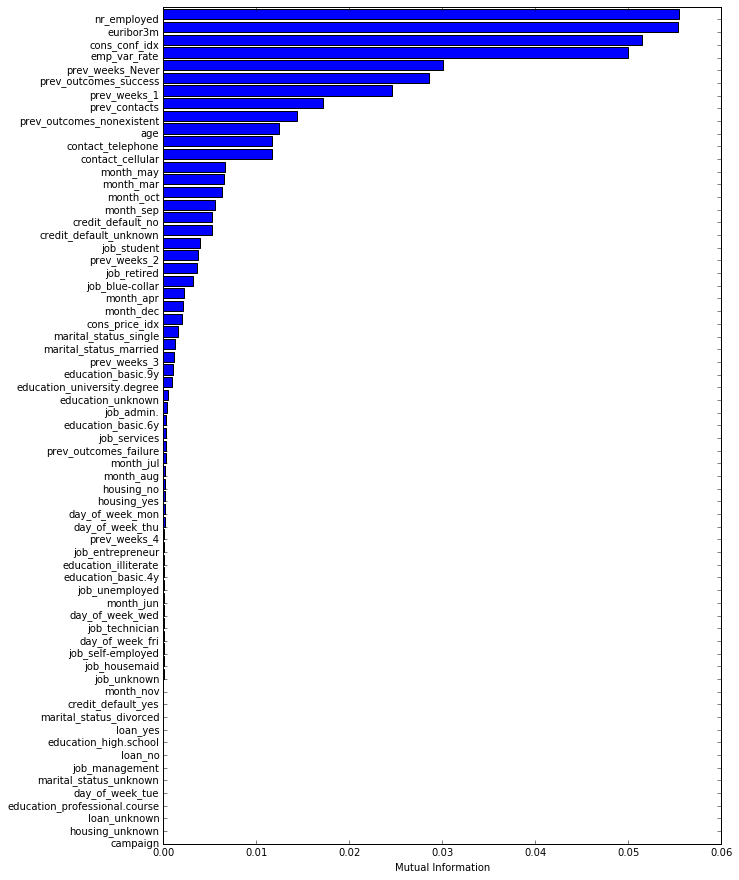

In [16]:
mutual_info = mi_continuous.tolist() + mi_categorical.tolist()
mutual_info_columns = X_train[continuous_cols].columns.tolist() + categorical_train_dummies.columns.tolist()
plot_mutual_info(mutual_info, mutual_info_columns)

### PCA

To look for further underlying structure in the data, we perform PCA on the whole dataset. We preprocess the data by scaling the continuous features to a mean of 0 and standard deviation of 1, then we label encode and one-hot encode the categorical features.

In [18]:
le = LabelEncoder()
for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_cv[col] = le.transform(X_cv[col])
    X_test[col] = le.transform(X_test[col])

/Users/adamcoviensky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
X_whole = pd.concat((X_train, X_cv, X_test))
y_whole = pd.concat((y_train, y_cv, y_test))
X_whole, y_whole = shuffle(X_whole, y_whole, random_state=42)

In [20]:
X_scaled = StandardScaler().fit_transform(X_whole[continuous_cols])
X_onehot = OneHotEncoder(handle_unknown='ignore').fit_transform(X_whole[categorical_cols])
X_mapped = hstack((X_scaled, X_onehot)).toarray()

In [21]:
pca_mapped = PCA(n_components=3)
X_pca_mapped = pca_mapped.fit_transform(X_mapped)

In [22]:
def plot_PCA(n_components, X_pca, y_whole):
    combs = list(itertools.combinations(range(n_components), 2))
    
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(wspace=0.3)
    
    key = {0: ('#1b9e77', 'no'), 1: ('#d95f02', 'yes')}
    labels = {0: 'First Principal Component', 1: 'Second Principal Component', 2: 'Third Principal Component'}
    
    for i in range(1,len(combs)+1):
        ax = fig.add_subplot(3,3,i)
        comb = combs[i-1]
        ax.scatter(X_pca[:,comb[0]], X_pca[:,comb[1]], c=[key[index][0] for index in y_whole], s=50)
        ax.set_xlabel(labels[comb[0]])
        ax.set_ylabel(labels[comb[1]])
            
    plt.show()

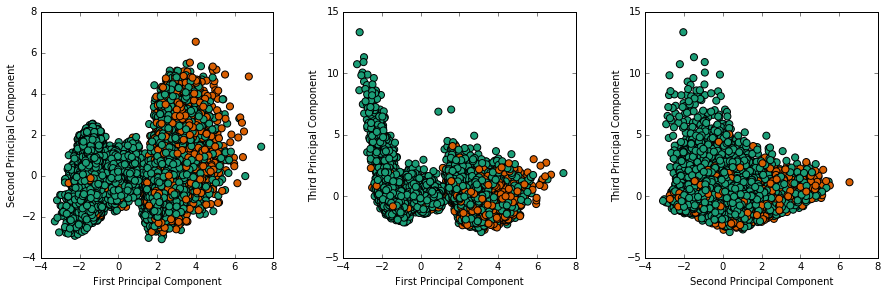

In [23]:
plot_PCA(3, X_pca_mapped, y_whole)

The results of the PCA don't reveal a very significant pattern - while there do seem to be groups of data that are much less likely to subscribe, the subscribers don't seem to be easily separable.

### Individual Models

The next step was to run individual models to see how they would perform. For each model, we perform One Hot Encoding on our categorical features and scale the continuous features. We then use random undersampling to deal with the imbalance of classes while reducing the size of the dataset, and select the best features according to mutual_information. Finally, we calculate second-degree polynomial features and remove unnecessary features by variance.

We used grid search to find the best parameters for each model based on ROC area under the curve.

In [24]:
mask_cat = [x in categorical_cols for x in X_train.columns.tolist()]

In [25]:
class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy, with_mean, with_std)

    def fit(self, X, y=None):
        self.scaler.fit(X.toarray()[:,:8], y)
        return self

    def transform(self, X, y=None, copy=None):
        X_scaled = self.scaler.transform(X.toarray()[:,:8])
        X_not_scaled = X.toarray()[:,8:]
        return np.concatenate((X_not_scaled, X_scaled), axis=1)

In [26]:
def make_indiv_pipeline(classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), 
                             SelectPercentile(score_func = mutual_info_classif),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [27]:
def train_indiv_pipeline(pipe, params, X_train, y_train):
    grid = GridSearchCV(pipe, params, cv=3, scoring='roc_auc')
    grid.fit(X_train, y_train)
    return grid

In [28]:
def score_indiv_pipeline(grid, X_test, y_test):
    print('The best score from grid search was {}'.format(grid.best_score_))
    print('The best parameters from grid search were {}'.format(grid.best_params_))
    print('The cross-validation score using these parameters was {}'
          .format(roc_auc_score(y_test, grid.predict_proba(X_test)[:,1])))

### K Nearest Neighbours

In [29]:
pipe_knn = make_indiv_pipeline(KNeighborsClassifier())
params_knn = {'selectpercentile__percentile': [50, 60, 70, 80], 
              'kneighborsclassifier__n_neighbors': [12, 13, 14, 15, 16]}
grid_knn = train_indiv_pipeline(pipe_knn, params_knn, X_train, y_train)
score_indiv_pipeline(grid_knn, X_cv, y_cv)

The best score from grid search was 0.759725271212
The best parameters from grid search were {'selectpercentile__percentile': 60, 'kneighborsclassifier__n_neighbors': 16}
The cross-validation score using these parameters was 0.770155173462


### Logistic Regression

In [30]:
pipe_lr = make_indiv_pipeline(LogisticRegression())
params_lr = {'selectpercentile__percentile': [40, 50, 60, 70], 
              'logisticregression__C': np.logspace(-3, -1, 3)}
grid_lr = train_indiv_pipeline(pipe_lr, params_lr, X_train, y_train)
score_indiv_pipeline(grid_lr, X_cv, y_cv)

The best score from grid search was 0.785908445054
The best parameters from grid search were {'selectpercentile__percentile': 70, 'logisticregression__C': 0.001}
The cross-validation score using these parameters was 0.807245080032


### Gaussian Process

In [31]:
pipe_gp = make_indiv_pipeline(GaussianProcessClassifier())
params_gp = {'selectpercentile__percentile': [5, 10, 15]}
grid_gp = train_indiv_pipeline(pipe_gp, params_gp, X_train, y_train)
score_indiv_pipeline(grid_gp, X_cv, y_cv)

The best score from grid search was 0.5
The best parameters from grid search were {'selectpercentile__percentile': 5}
The cross-validation score using these parameters was 0.5


### Decision Trees

In [32]:
pipe_tree = make_indiv_pipeline(DecisionTreeClassifier())
params_tree = {'selectpercentile__percentile': [40, 50, 60], 
              'decisiontreeclassifier__max_depth': range(3,5)}
grid_tree = train_indiv_pipeline(pipe_tree, params_tree, X_train, y_train)
score_indiv_pipeline(grid_tree, X_cv, y_cv)

The best score from grid search was 0.765834694458
The best parameters from grid search were {'selectpercentile__percentile': 40, 'decisiontreeclassifier__max_depth': 4}
The cross-validation score using these parameters was 0.775718967404


### Random Forest

In [33]:
pipe_forest = make_indiv_pipeline(RandomForestClassifier())
params_forest = {'selectpercentile__percentile': [20, 30, 40, 50], 
            'randomforestclassifier__max_depth': range(3,5),
            'randomforestclassifier__max_features': [5, 10, 15],
            'randomforestclassifier__warm_start': [True, False]}
grid_forest = train_indiv_pipeline(pipe_forest, params_forest, X_train, y_train)
score_indiv_pipeline(grid_forest, X_cv, y_cv)

The best score from grid search was 0.784760356429
The best parameters from grid search were {'selectpercentile__percentile': 50, 'randomforestclassifier__warm_start': False, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 15}
The cross-validation score using these parameters was 0.803323284773


### Gradient Boosted Trees

In [34]:
pipe_gb = make_indiv_pipeline(GradientBoostingClassifier())
params_gb = {'selectpercentile__percentile': [30, 40, 50, 60], 
              'gradientboostingclassifier__max_depth': range(3,5),
            'gradientboostingclassifier__warm_start': [True, False]}
grid_gb = train_indiv_pipeline(pipe_gb, params_gb, X_train, y_train)
score_indiv_pipeline(grid_gb, X_cv, y_cv)

The best score from grid search was 0.779670160511
The best parameters from grid search were {'gradientboostingclassifier__warm_start': True, 'selectpercentile__percentile': 60, 'gradientboostingclassifier__max_depth': 3}
The cross-validation score using these parameters was 0.794230962775


### Ada Boost Classifier

In [35]:
pipe_ada = make_indiv_pipeline(AdaBoostClassifier())
params_ada = {'selectpercentile__percentile': [10, 20, 30, 40, 50], 
            'adaboostclassifier__n_estimators': [30, 40, 50, 60, 70]}
grid_ada = train_indiv_pipeline(pipe_ada, params_ada, X_train, y_train)
score_indiv_pipeline(grid_ada, X_cv, y_cv)

The best score from grid search was 0.776113370334
The best parameters from grid search were {'selectpercentile__percentile': 40, 'adaboostclassifier__n_estimators': 30}
The cross-validation score using these parameters was 0.793492653071


#### Summary of Cross-Validation Scores

0.803 Gradient Boosted Trees

0.802 Logistic Regression

0.802 Random Forest

0.799 AdaBoost

0.785 Decision Tree

0.770 K-Nearest Neighbors

0.5 Gaussian Process

After grid-searching each individual model, we create a pipeline with the best parameters for each

In [36]:
def make_final_indiv_pipeline(percentile, classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), 
                             SelectPercentile(score_func = mutual_info_classif, percentile = percentile),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [37]:
pipe_final_knn = make_final_indiv_pipeline(50, KNeighborsClassifier(n_neighbors=15))
pipe_final_lr = make_final_indiv_pipeline(70, LogisticRegression(C=0.1))
pipe_final_gp = make_final_indiv_pipeline(5, GaussianProcessClassifier())
pipe_final_tree = make_final_indiv_pipeline(60, DecisionTreeClassifier(max_depth=4))
pipe_final_forest = make_final_indiv_pipeline(20, RandomForestClassifier(max_depth=4, max_features=15, warm_start=True))
pipe_final_gb = make_final_indiv_pipeline(40, GradientBoostingClassifier(max_depth=3, warm_start=False))
pipe_final_ada = make_final_indiv_pipeline(30, AdaBoostClassifier(n_estimators=30))

### Ensembles

Next, we tried using ensembles of the previously developed pipelines - first, a soft-voting classifier with all models and one with the four best-performing models.

In [38]:
def score_ensemble(ensemble, X, y):
    return roc_auc_score(y, ensemble.predict_proba(X)[:,1])

In [39]:
first_ensemble_all_soft = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                          ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                            ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                            voting = 'soft')
first_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(first_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(first_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.838209968954
Cross-validation score: 0.804547641812


In [40]:
ensemble_highest = VotingClassifier(estimators=[('lr', pipe_final_lr), ('forest', pipe_final_forest), 
                                    ('gb', pipe_final_gb), ('ada', pipe_final_ada)], voting = 'soft')
ensemble_highest.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(ensemble_highest, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(ensemble_highest, X_cv, y_cv)))

Training score: 0.819966878716
Cross-validation score: 0.807182964519


#### Trying the ensembles with doing PCA first

In [41]:
def make_pca_pipeline(percentile, classifier):
    pipe = make_imb_pipeline(OneHotEncoder(categorical_features=mask_cat, handle_unknown='ignore'),
                             CustomScaler(), RandomUnderSampler(), PCA(n_components=5),
                             SelectPercentile(score_func = mutual_info_classif, percentile = percentile),
                            PolynomialFeatures(degree = 2), VarianceThreshold(), classifier)
    return pipe

In [42]:
pipe_pca_knn = make_pca_pipeline(50, KNeighborsClassifier(n_neighbors=15))
pipe_pca_lr = make_pca_pipeline(70, LogisticRegression(C=0.1))
pipe_pca_gp = make_pca_pipeline(5, GaussianProcessClassifier())
pipe_pca_tree = make_pca_pipeline(60, DecisionTreeClassifier(max_depth=4))
pipe_pca_forest = make_pca_pipeline(20, RandomForestClassifier(max_depth=4, warm_start=True))
pipe_pca_gb = make_pca_pipeline(40, GradientBoostingClassifier(max_depth=3, warm_start=False))
pipe_pca_ada = make_final_indiv_pipeline(30, AdaBoostClassifier(n_estimators=30))

In [43]:
pca_ensemble_all_soft = VotingClassifier(estimators=[('knn', pipe_pca_knn), 
                          ('lr', pipe_pca_lr), ('gp', pipe_pca_gp), ('tree', pipe_pca_tree),
                            ('forest', pipe_pca_forest), ('gb', pipe_pca_gb), ('ada', pipe_pca_ada)],
                            voting = 'soft')
pca_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.823790724829
Cross-validation score: 0.786815104396


In [44]:
pca_ensemble_all_soft = VotingClassifier(estimators=[('lr', pipe_pca_lr), ('forest', pipe_pca_forest), 
                                                     ('ada', pipe_pca_ada)], voting = 'soft')
pca_ensemble_all_soft.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(pca_ensemble_all_soft, X_cv, y_cv)))

Training score: 0.777084751536
Cross-validation score: 0.783049384192


We attempted a brute force approach to optimize the classifier weights

In [ ]:
np.random.seed(42)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            for w4 in range(1,4):
                for w5 in range(1,4):
                    for w6 in range(1,4):
                        for w7 in range(1,4):
                            if len(set((w1,w2,w3,w4,w5,w6,w7))) == 1: # skip if all weights are equal
                                continue

                            eclf = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                                  ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                                    ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                                    voting = 'soft', weights=[w1,w2,w3,w4,w5,w6,w7])

                            scores = cross_val_score(estimator=eclf, X=X_train, y=y_train, cv=3, scoring='roc_auc')

                            df.loc[i] = [w1, w2, w3, w4, w5, w6, w7, scores.mean(), scores.std()]
                            i += 1

In [ ]:
df.sort_values(by=['mean', 'std'], ascending=False).head()

We found the best weights to be: The best weights were: w1=1 w2=1 w3=3 w4=1 w5=2 w6=3 w7=1

In [45]:
finalvote = VotingClassifier(estimators=[('knn', pipe_final_knn), 
                            ('lr', pipe_final_lr), ('gp', pipe_final_gp), ('tree', pipe_final_tree),
                            ('forest', pipe_final_forest), ('gb', pipe_final_gb), ('ada', pipe_final_ada)],
                            voting = 'soft', weights=[1,1,3,1,2,3,1])
finalvote.fit(X_train, y_train)
print('Training score: {}'.format(score_ensemble(finalvote, X_train, y_train)))
print('Cross-validation score: {}'.format(score_ensemble(finalvote, X_cv, y_cv)))

Training score: 0.863188937626
Cross-validation score: 0.808335639732


#### Second-Stage Logistic Regression Model

We finally tried using the predicted probabilities as features in a second-stage logistic regression model.

In [46]:
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,14)[:, 1::2], validate = False)

first_stage = make_pipeline(finalvote, reshaper)
transform_cv = cross_val_predict(first_stage, X_train, y_train, cv = 3, method='transform')

In [47]:
second_stage = LogisticRegressionCV(Cs=5, scoring= "roc_auc").fit(transform_cv, y_train)

In [48]:
print('Best C value: {}'.format(second_stage.C_))
print('Cross-validation scores: {}'.format(second_stage.scores_))
print('Cross-validation data score: {}'.format(roc_auc_score(y_cv, second_stage.predict_proba(first_stage.transform(X_cv))[:,1])))

Best C value: [ 1.]
Cross-validation scores: {1: array([[ 0.7805286 ,  0.78093353,  0.78262087,  0.7825881 ,  0.78258784],
       [ 0.79797152,  0.79826506,  0.79862308,  0.79860866,  0.79860866],
       [ 0.78483527,  0.78501087,  0.78514454,  0.78512147,  0.78512121]])}
Cross-validation data score: 0.809351765653


### Final Ensemble

In [49]:
X_traincv = pd.concat((X_train, X_cv))
y_traincv = pd.concat((y_train, y_cv))

In [50]:
finalvote.fit(X_traincv, y_traincv)

VotingClassifier(estimators=[('knn', Pipeline(steps=[('onehotencoder', OneHotEncoder(categorical_features=[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True],
       dtype=<type 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', s...SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None))]))],
         n_jobs=1, voting='soft', weights=[1, 1, 3, 1, 2, 3, 1])

In [51]:
print('Training score: {}'.format(roc_auc_score(y_traincv, second_stage.predict_proba(first_stage.transform(X_traincv))[:,1])))
print('Test score: {}'.format(roc_auc_score(y_test, second_stage.predict_proba(first_stage.transform(X_test))[:,1])))

Training score: 0.807621032863
Test score: 0.793829602811


Ultimately, the final ensemble's AUC ROC score was about 79%.